In [1]:
import time
import os
from functools import cmp_to_key
from time import sleep
import mediapipe as mp
import cv2 as cv
import numpy as np
from commonfunctions import *
import pyautogui as pg

# import scipy.ndimage import imread


In [2]:
# get threshold value
def calcThreshold(hist, accHist, iFrom, iTo):
    iFrom, iTo = int(iFrom), int(iTo)
    numOfPixels = accHist[iTo] - (accHist[iFrom - 1] if iFrom > 0 else 0)
    mean = np.sum(
        hist[iFrom:iTo+1] * np.arange(iFrom, iTo+1)
    ) / numOfPixels
    return round(mean)

# np.arange([1 , 2] < 3)


def avgThreshold(hist, accHist, Tinit):
    mean1 = calcThreshold(hist, accHist, 0, Tinit - 1)
    mean2 = calcThreshold(hist, accHist, Tinit, hist.shape[0] - 1)
    newThreshold = round((mean1 + mean2) / 2)
    return newThreshold if Tinit == newThreshold else avgThreshold(hist, accHist, newThreshold)


def getGlobalThreshold(img):
    img2 = np.copy(img)
    hist = np.histogram(img2, bins=np.arange(256))[0]
    accHist = np.cumsum(hist)
    Tinit = calcThreshold(hist, accHist, 0, hist.shape[0] - 1)
    return avgThreshold(hist, accHist, Tinit)# get threshold


In [3]:
def get_image_with_skin_color(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = (B - Y) * 0.564 + 128
    Cr = (R - Y) * 0.713 + 128
    outImg = (Cb >= 77) * (Cb <= 127) * (Cr >= 133) * (Cr <= 187)
    return outImg


def get_image_with_skin_color_hsv(img):
    lower_hsv = np.array([0, 48, 80], dtype="uint8")
    upper_hsv = np.array([20, 255, 255], dtype="uint8")
    hsv_image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    skin_region = cv.inRange(hsv_image, lower_hsv, upper_hsv)
    return skin_region



In [4]:

def test_all_images():
    for file_name in os.listdir('./images/'):
        if not file_name.startswith('image'):
            continue
        img = cv.imread(f'./images/{file_name}')
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        test1 = get_image_with_skin_color(img)
        test2 = get_image_with_skin_color_hsv(img)
        # show_images([img, test1, test2], ['img', 'y', 'hsv'])


# test_all_images()


In [5]:
def enhance_image(img):
    se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).astype('uint8')
    enhanced_image = np.array(img).astype('uint8')
    enhanced_image = cv.dilate(
        enhanced_image, se, iterations=7
    )
    enhanced_image = cv.erode(
        enhanced_image, se, iterations=4
    )
    return enhanced_image




In [6]:

def compare(item1, item2):
    return item1[0] - item2[0]


def detectHand(binaryImg, mainImg):
    contours = find_contours(binaryImg,  fully_connected='high')
    contours = [
        [
            int(np.min(contour[:, 0])), int(np.max(contour[:, 0])),
            int(np.min(contour[:, 1])), int(np.max(contour[:, 1]))
        ]
        for contour in contours]
    contours = sorted(contours, key=cmp_to_key(compare))
    # temp_image = np.zeros_like(mainImg)
    for contour in contours:
        [Xmin, Xmax, Ymin, Ymax] = contour
        if Xmax - Xmin >= 50 and Ymax - Ymin >= 50:
            temp_image = mainImg[max(Xmin-70,0):min(Xmax+70,mainImg.shape[0]), max(Ymin-70,0):min(Ymax+70,mainImg.shape[1])]
            # show_images([temp_image,binaryImg[Xmin:Xmax, Ymin:Ymax]])
            mp_hands = mp.solutions.hands
            hand = mp_hands.Hands()
            result = hand.process(temp_image)
            if result.multi_hand_landmarks:
                return np.array(binaryImg[Xmin:Xmax, Ymin:Ymax]),(Xmin,Xmax,Ymin,Ymax)
    return None, (0, 0)

In [7]:
# # test detectHand
# img1 = cv.imread('./images/image20.jpg')
# img2 = cv.imread('./images/image21.jpg')
# img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
# img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

# b1 = get_image_with_skin_color(img1)
# b2 = get_image_with_skin_color(img2)
# show_images([img1, b1])
# print(img1.shape)
# handImg, _ = detectHand(b1, img1)
# show_images([handImg])
# print('--------------------------------')
# detectHand(b2, img2)


In [8]:
def captureImage(cap):
    success, img = cap.read()
    img = cv.flip(img, 1)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # print(imgRGB)
    if cv.waitKey(1) & 0xff == ord('q'):
        cv.destroyAllWindows()
        cap.release()
        exit(0)
    return imgRGB


In [9]:
def compareFingers(contour1, contour2):
    return int(np.max(contour1[:, 0])-np.min(contour1[:, 0])) - int(np.max(contour2[:, 0])-np.min(contour2[:, 0]))


def detectFingers(original):
    if original is None:
        return [None, None]
    image = original > 0.9
    # show_images([image])
    numberOfIteration = (image.shape[0]+image.shape[1])//12
    # print(image.shape, numberOfIteration)
    # kernel = np.ones((5, 5), np.uint8)

    for i in range(numberOfIteration):
        image = binary_erosion(image)
    for i in range(numberOfIteration):
        image = binary_dilation(image)
    contours = find_contours(image)
    center = ()
    radius = 0

    contours = sorted(contours, key=cmp_to_key(compareFingers))
    if not len(contours) > 0:
        return None, None
    Ymin = int(np.min(contours[-1][:, 1]))
    Ymax = int(np.max(contours[-1][:, 1]))
    Xmin = int(np.min(contours[-1][:, 0]))
    Xmax = int(np.max(contours[-1][:, 0]))
    center = ((Xmin+Xmax)//2, (Ymin+Ymax)//2)
    radius = center[0] - Xmin

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if math.dist((i, j), center) < radius:
                original[i, j] = 0

    for i in range(5):
        original = binary_erosion(original, [[1, 1, 1] for _ in range(10)])
    for i in range(5):
        original = binary_dilation(original, [[1, 1, 1] for _ in range(10)])
    show_images([original, image])

    fingersCotours = find_contours(original)
    fingersCotours = sorted(fingersCotours, key=cmp_to_key(compareFingers))
    if len(fingersCotours) == 0:
        return None, None
    contour = fingersCotours[-1]
    Ymin = int(np.min(contour[:, 1]))
    Ymax = int(np.max(contour[:, 1]))
    Xmin = int(np.min(contour[:, 0]))
    Xmax = int(np.max(contour[:, 0]))
    img = np.copy(original)

    img[Xmin:Xmax, Ymin:Ymax] = 0
    img = original.astype(int) - img.astype(int)
    return (Xmax - Xmin), (Xmax, (Ymin+Ymax)//2)


In [10]:


def get_info_from_fingers(fingers_info):
    length = len(fingers_info)
    if length == 0:
        return None
    if length == 1:
        return fingers_info[0]


In [11]:
# moving mouse coordinates
def move_mouse_by_defference(x_new, y_new):
    print(x_new, y_new)
    x0, y0 = pg.position()
    pg.moveTo(x0 + x_new, y0 + y_new)


# move_mouse_by_defference(100, 0)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


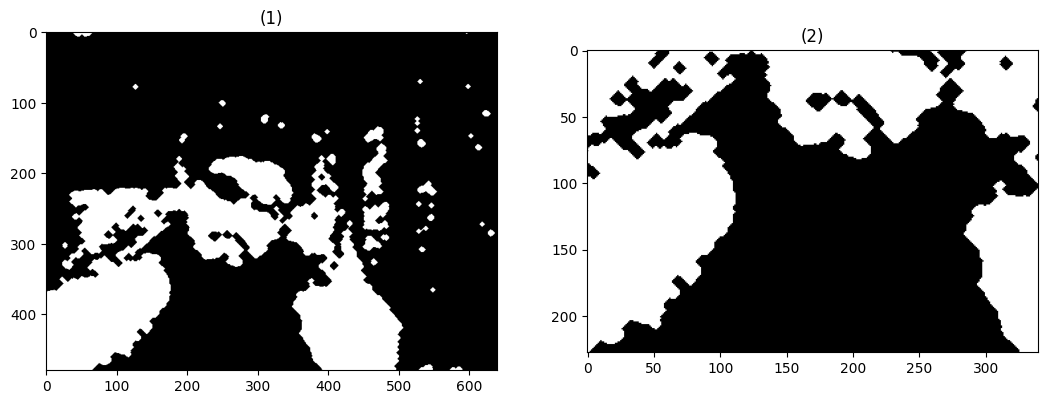

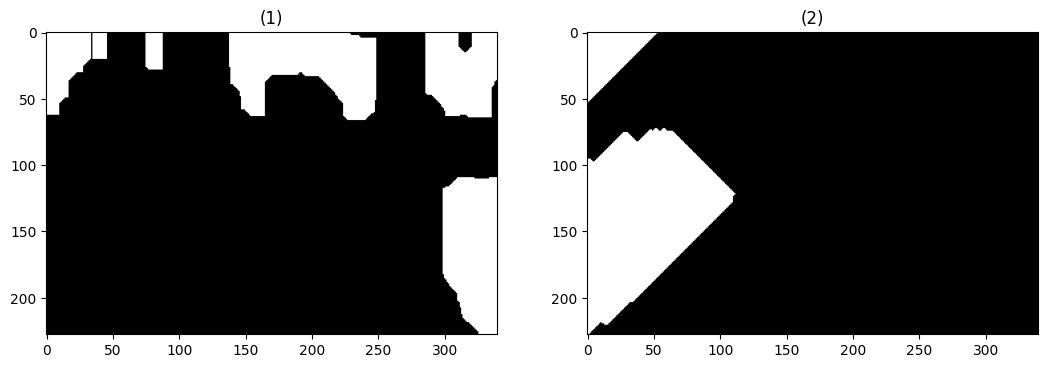

0 0


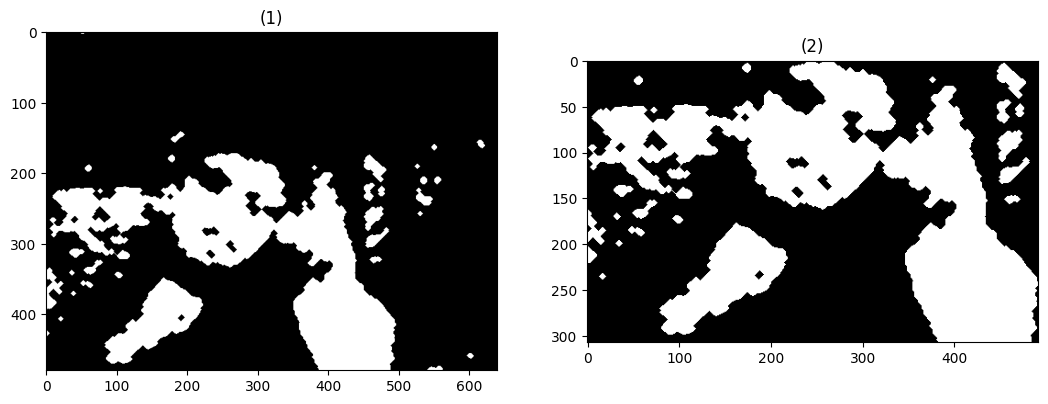

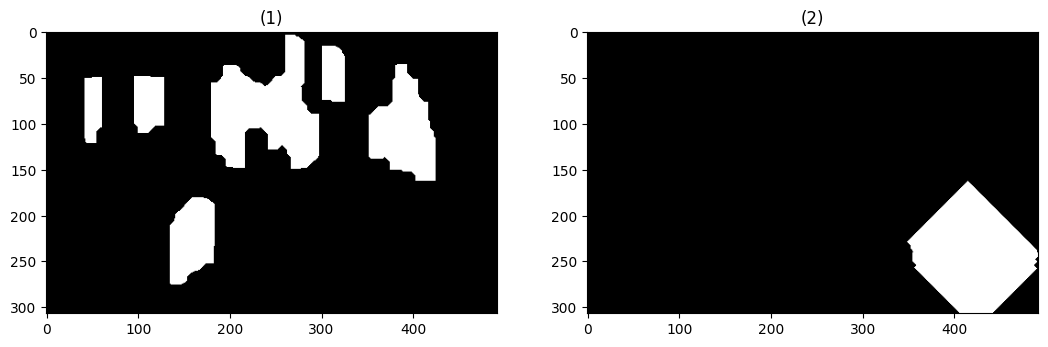

157 80


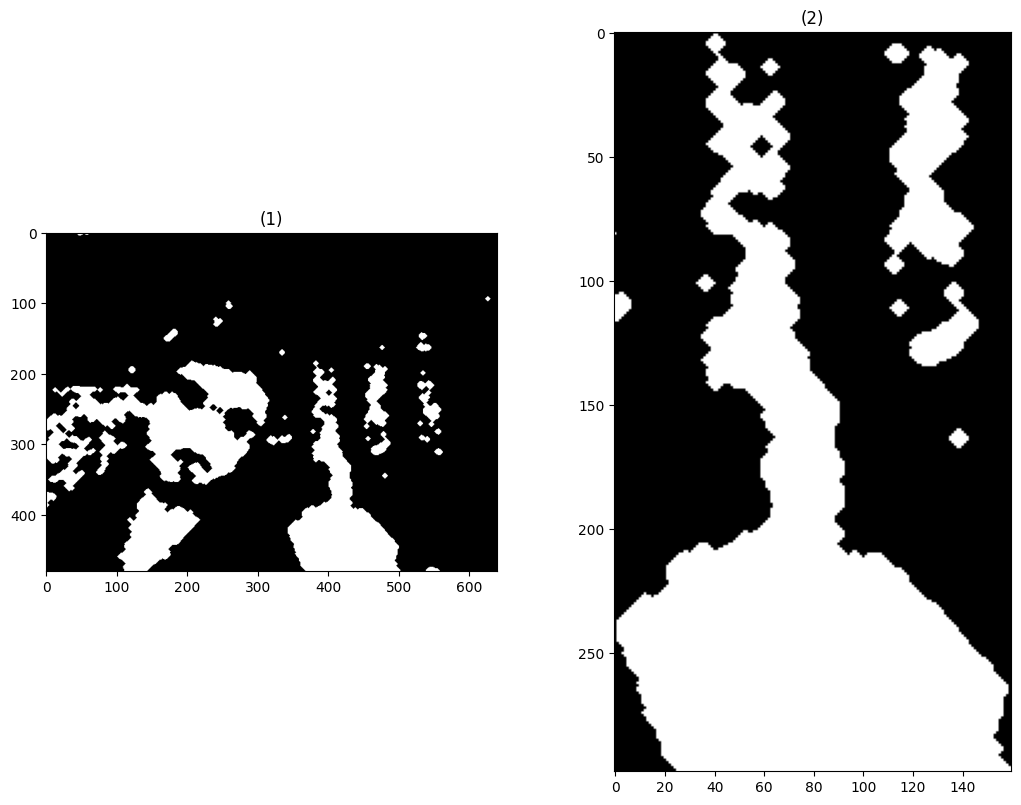

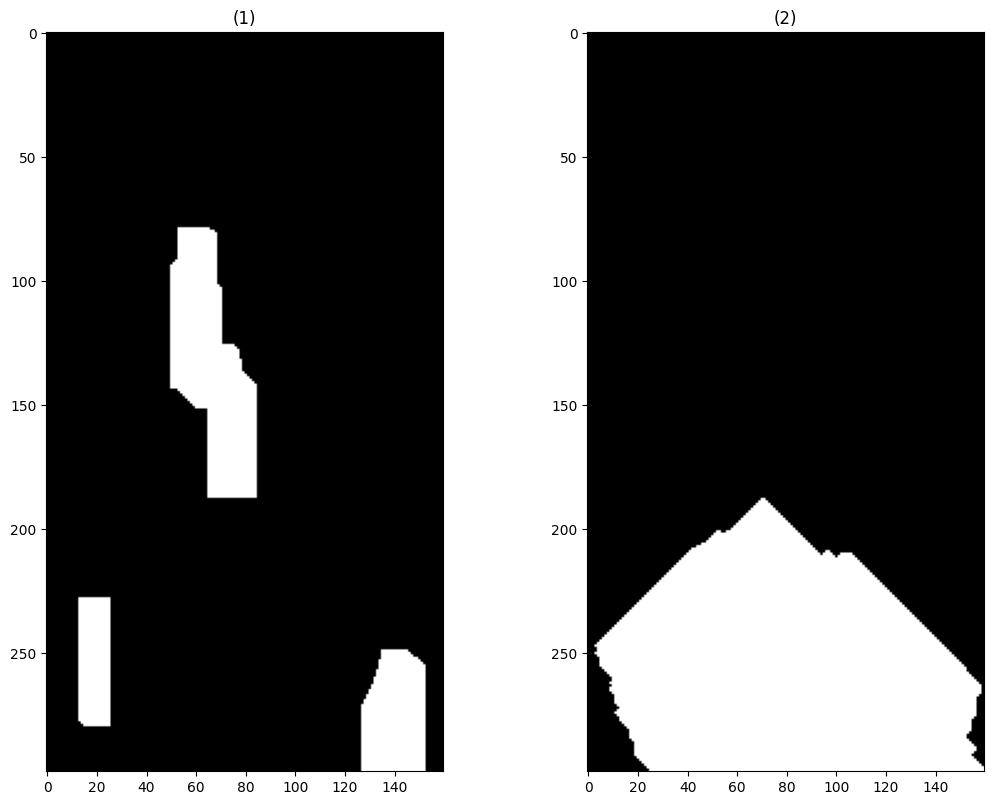

-47 172


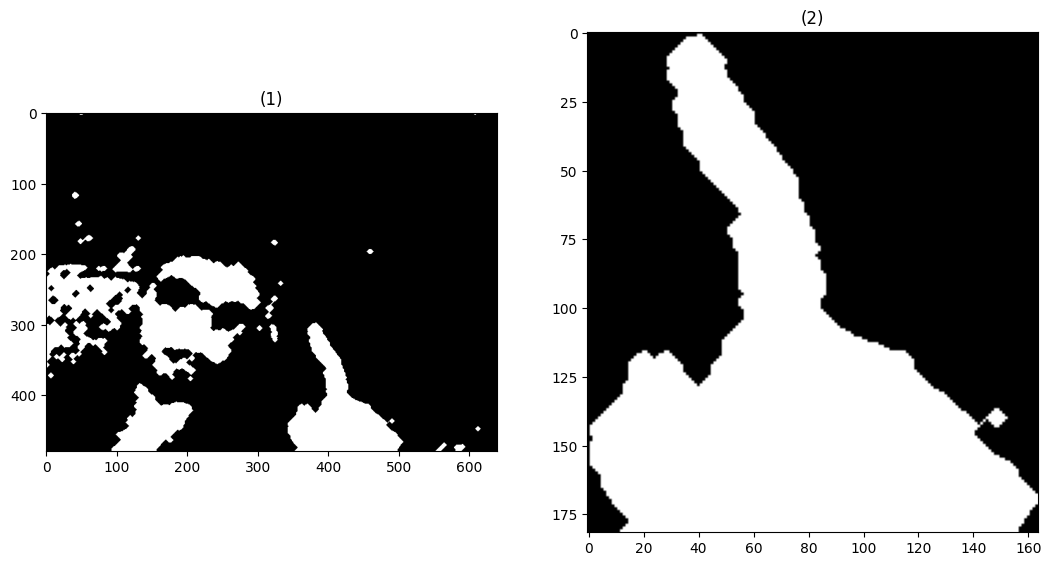

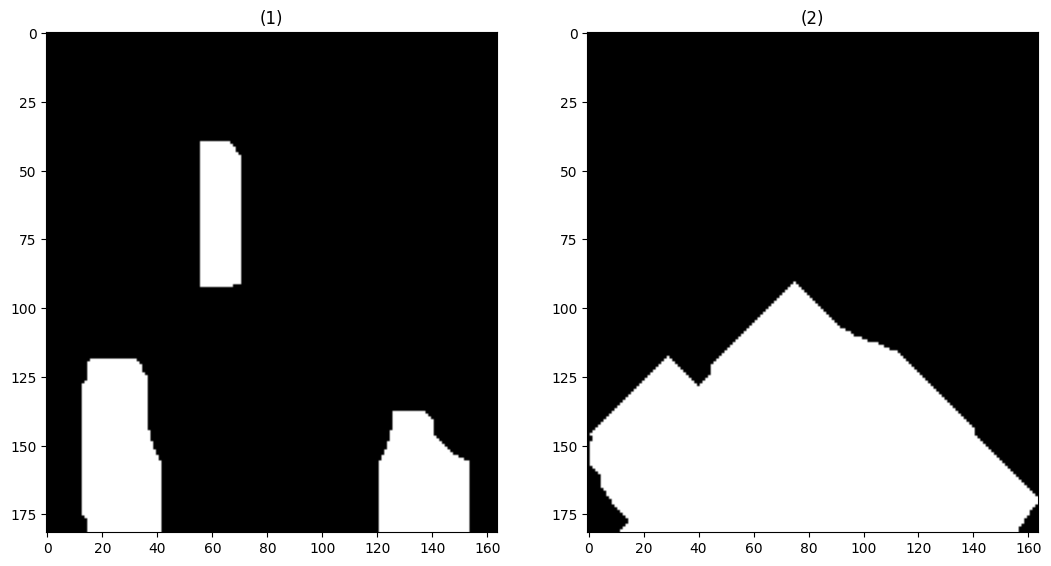

-110 40


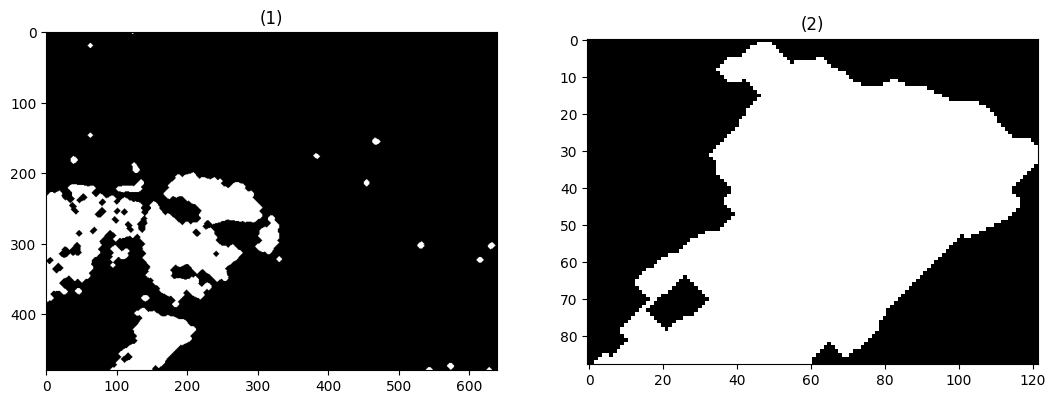

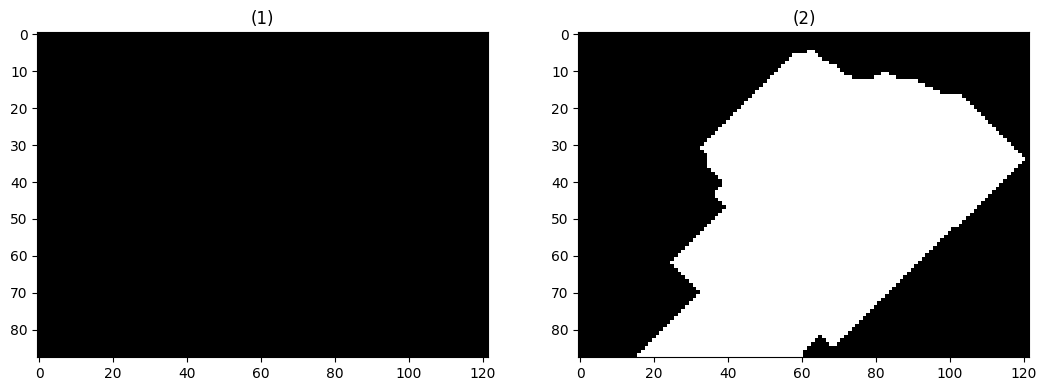

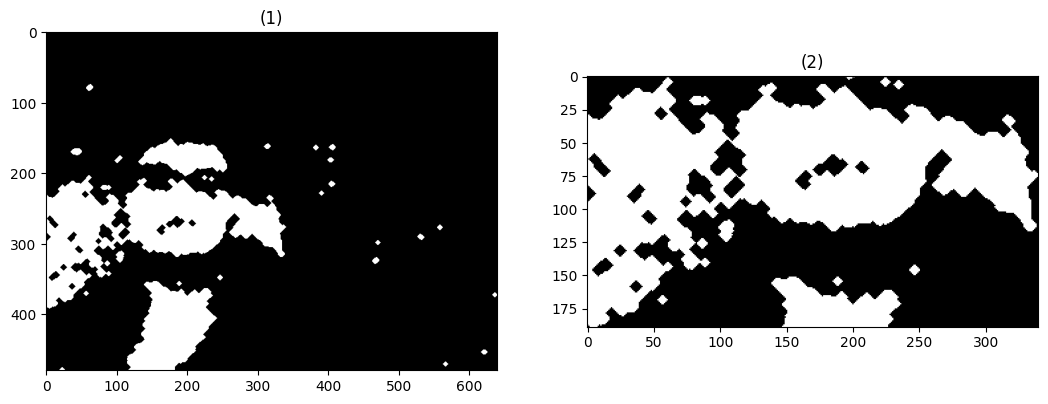

: 

: 

In [12]:
def main():
    #
    cap = cv.VideoCapture(0)
    cap.set(cv.CAP_PROP_BUFFERSIZE, 2)
    currentPosition = (0, 0)
    while True:
        img = captureImage(cap)
        # show_images([img])
        sleep(0.2)
        binary_image = get_image_with_skin_color(img)
        # show_images([binary_image])
        binary_image = enhance_image(binary_image)
        # show_images([binary_image])
        hand_image, hand_margin = detectHand(binary_image, img)
        show_images([binary_image, hand_image]
                    ) if hand_image is not None else None
        # print(hand_image)
        length, finger_center = detectFingers(hand_image)
        if(finger_center):
            finger_center_in_image = (
                finger_center[0]+hand_margin[0], finger_center[1]+hand_margin[1])
            if(currentPosition == (0, 0)):
                currentPosition = finger_center_in_image
            move_mouse_by_defference(
                currentPosition[0]-finger_center_in_image[0], currentPosition[1]-finger_center_in_image[1])
            currentPosition = finger_center_in_image
            # print(length,finger_center)

        # information = get_info_from_fingers(fingers)


if __name__ == "__main__":
    main()
